# FERM 536 – Demystifying Turkish Economic Data  - Bonus HW II

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Use the provided “CPI_All_March2024.csv” Data file provided for this Assignment


In [2]:
# Load and preprocess data
financial_data = pd.read_csv("CPI_All_March2024.csv")
financial_data['Month'] = pd.to_datetime(financial_data['Month'])
financial_data.reset_index(drop=True, inplace=True)

financial_data

,Month,CPI_SA,Core_SA,Services_SA,PPI_SA,CoreGoods_SA,PPI_Mfg_SA,USDTRY,EURTRY
0,2003-01-01,94.496018,95.154148,93.003485,94.318481,96.116364,98.217654,1.659829,1.760544
1,2003-02-01,95.971867,96.626121,94.218492,97.282867,97.311128,100.074652,1.627145,1.754147
2,2003-03-01,97.551628,97.816864,95.564773,100.400298,98.311239,101.858631,1.659379,1.792435
3,2003-04-01,98.423702,98.585492,96.820349,102.167899,99.078875,100.489287,1.631121,1.767996
4,2003-05-01,99.294378,99.137006,98.107806,101.533658,99.125696,98.351026,1.493972,1.720026
...,...,...,...,...,...,...,...,...,...
249,2023-10-01,1761.497370,1577.963769,1696.204691,2803.290000,1095.750048,2689.500000,27.821073,29.383195
250,2023-11-01,1819.562623,1630.309610,1785.775536,2882.040000,1123.086177,2750.150000,28.611334,30.874732
251,2023-12-01,1880.172281,1691.448408,1867.537372,2915.020000,1157.638324,2805.260000,29.048710,31.686364
252,2024-01-01,1971.324923,1770.137911,2002.875473,3035.590000,1193.823816,2951.380000,30.026725,32.783775


### Month: The date column, formatted as YYYY-MM-DD, set as index
### CPI_SA: Consumer Price Index, seasonally adjusted.
### Core_SA: Core inflation index, excluding volatile items like food and energy, seasonally adjusted.
### Services_SA: Services component of the CPI, seasonally adjusted.
### PPI_SA: Producer Price Index, seasonally adjusted.
### CoreGoods_SA: Core goods index, presumably excluding food and energy, seasonally adjusted.
### PPI_Mfg_SA: Producer Price Index for manufacturing, seasonally adjusted.
### USDTRY: Exchange rate between the US dollar and Turkish lira.
### EURTRY: Exchange rate between the Euro and Turkish lira.

## a) Rolling FX Pass-through estimate

## - Estimate several specifications to estimate FX pass-through using rolling regression. Your models may include lagged dependent variable, PPI and several lags of TRY Basket.


In [3]:
# Calculating the average currency rate as 'Currency_Avg'
financial_data['Currency_Avg'] = financial_data[['USDTRY', 'EURTRY']].mean(axis=1)

# Introducing lagged features for analysis
for lag in range(1, 4):
    financial_data[f'TRY_Basket_L{lag}'] = financial_data['Currency_Avg'].shift(lag)

financial_data['CPI_L1'] = financial_data['CPI_SA'].shift(1)
financial_data['PPI_L1'] = financial_data['PPI_SA'].shift(1)

# Removing missing values after lagging
final_data = financial_data.dropna()
final_data

,Month,CPI_SA,Core_SA,Services_SA,PPI_SA,CoreGoods_SA,PPI_Mfg_SA,USDTRY,EURTRY,Currency_Avg,TRY_Basket_L1,TRY_Basket_L2,TRY_Basket_L3,CPI_L1,PPI_L1
3,2003-04-01,98.423702,98.585492,96.820349,102.167899,99.078875,100.489287,1.631121,1.767996,1.699558,1.725907,1.690646,1.710187,97.551628,100.400298
4,2003-05-01,99.294378,99.137006,98.107806,101.533658,99.125696,98.351026,1.493972,1.720026,1.606999,1.699558,1.725907,1.690646,98.423702,102.167899
5,2003-06-01,100.151501,99.720271,99.479584,99.578542,99.422649,98.188614,1.422522,1.662939,1.542731,1.606999,1.699558,1.725907,99.294378,101.533658
6,2003-07-01,100.711418,100.469828,100.652883,99.044953,100.460289,98.469814,1.400477,1.593799,1.497138,1.542731,1.606999,1.699558,100.151501,99.578542
7,2003-08-01,101.344986,101.419747,101.902054,98.850544,101.208020,99.362362,1.400472,1.563904,1.482188,1.497138,1.542731,1.606999,100.711418,99.044953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2023-10-01,1761.497370,1577.963769,1696.204691,2803.290000,1095.750048,2689.500000,27.821073,29.383195,28.602134,27.905812,28.215026,27.838465,1706.373040,2749.980000
250,2023-11-01,1819.562623,1630.309610,1785.775536,2882.040000,1123.086177,2750.150000,28.611334,30.874732,29.743033,28.602134,27.905812,28.215026,1761.497370,2803.290000
251,2023-12-01,1880.172281,1691.448408,1867.537372,2915.020000,1157.638324,2805.260000,29.048710,31.686364,30.367537,29.743033,28.602134,27.905812,1819.562623,2882.040000
252,2024-01-01,1971.324923,1770.137911,2002.875473,3035.590000,1193.823816,2951.380000,30.026725,32.783775,31.405250,30.367537,29.743033,28.602134,1880.172281,2915.020000


In [4]:
# Initialize an empty list to store the results of rolling regressions
rolling_results = []

# Define different sets of independent variables for rolling regressions
independent_vars_sets = [
    ['Currency_Avg'],
    ['Currency_Avg', 'TRY_Basket_L1'],
    ['Currency_Avg', 'TRY_Basket_L1', 'TRY_Basket_L2'],
    ['Currency_Avg', 'TRY_Basket_L1', 'TRY_Basket_L2', 'TRY_Basket_L3'],
    ['Currency_Avg', 'TRY_Basket_L1', 'TRY_Basket_L2', 'TRY_Basket_L3', 'CPI_L1'],
    ['Currency_Avg', 'TRY_Basket_L1', 'TRY_Basket_L2', 'TRY_Basket_L3', 'CPI_L1', 'PPI_L1']
]

# Loop through each set of independent variables for rolling regression analysis
for i, vars_set in enumerate(independent_vars_sets, start=1):
    X = final_data[vars_set]
    X = sm.add_constant(X)  # Add a constant term to the regression

    # Define CPI_SA as the dependent variable
    y = final_data['CPI_SA']

    # Perform the rolling regression
    model_rolling = RollingOLS(y, X, window=int(len(final_data) * 0.2))
    results_rolling = model_rolling.fit()

    # Store the parameters of the last model in the results list
    rolling_results.append((i, results_rolling.params.tail(1)))

# Display the parameters of the last model for each set of independent variables
for model_num, params in rolling_results:
    print(f"Model {model_num} Parameters from the Latest Window:\n{params}\n")

Model 1 Parameters from the Latest Window:
        const  Currency_Avg
253 -8.475259     60.280495

Model 2 Parameters from the Latest Window:
         const  Currency_Avg  TRY_Basket_L1
253 -12.936051     12.147682      50.103176

Model 3 Parameters from the Latest Window:
         const  Currency_Avg  TRY_Basket_L1  TRY_Basket_L2
253 -18.265892       22.3106       7.209845      33.893321

Model 4 Parameters from the Latest Window:
         const  Currency_Avg  TRY_Basket_L1  TRY_Basket_L2  TRY_Basket_L3
253 -21.535156     14.449482       25.19766      -0.084119      24.843374

Model 5 Parameters from the Latest Window:
        const  Currency_Avg  TRY_Basket_L1  TRY_Basket_L2  TRY_Basket_L3  \
253 -15.80518     10.341554       9.362382      -7.495219         -4.903   

       CPI_L1  
253  0.915909  

Model 6 Parameters from the Latest Window:
         const  Currency_Avg  TRY_Basket_L1  TRY_Basket_L2  TRY_Basket_L3  \
253 -25.755052     10.858211      10.323385      -7.505978      -

### COMMENT: In the specified models, the dependent variable is CPI_SA, while the independent variables include the TRY Basket among others. The models' coefficients reveal the extent to which variations in the TRY Basket and additional factors have affected the CPI over a 250-month rolling window. Specifically, the coefficients associated with the TRY Basket and its lagged versions highlight the temporal impact on CPI SA across various lag intervals, illustrating the dynamic relationship between these variables and the CPI.

## - What do you observe about the FX pass-through over time? Has it been increasing/decreasing? Over which period?


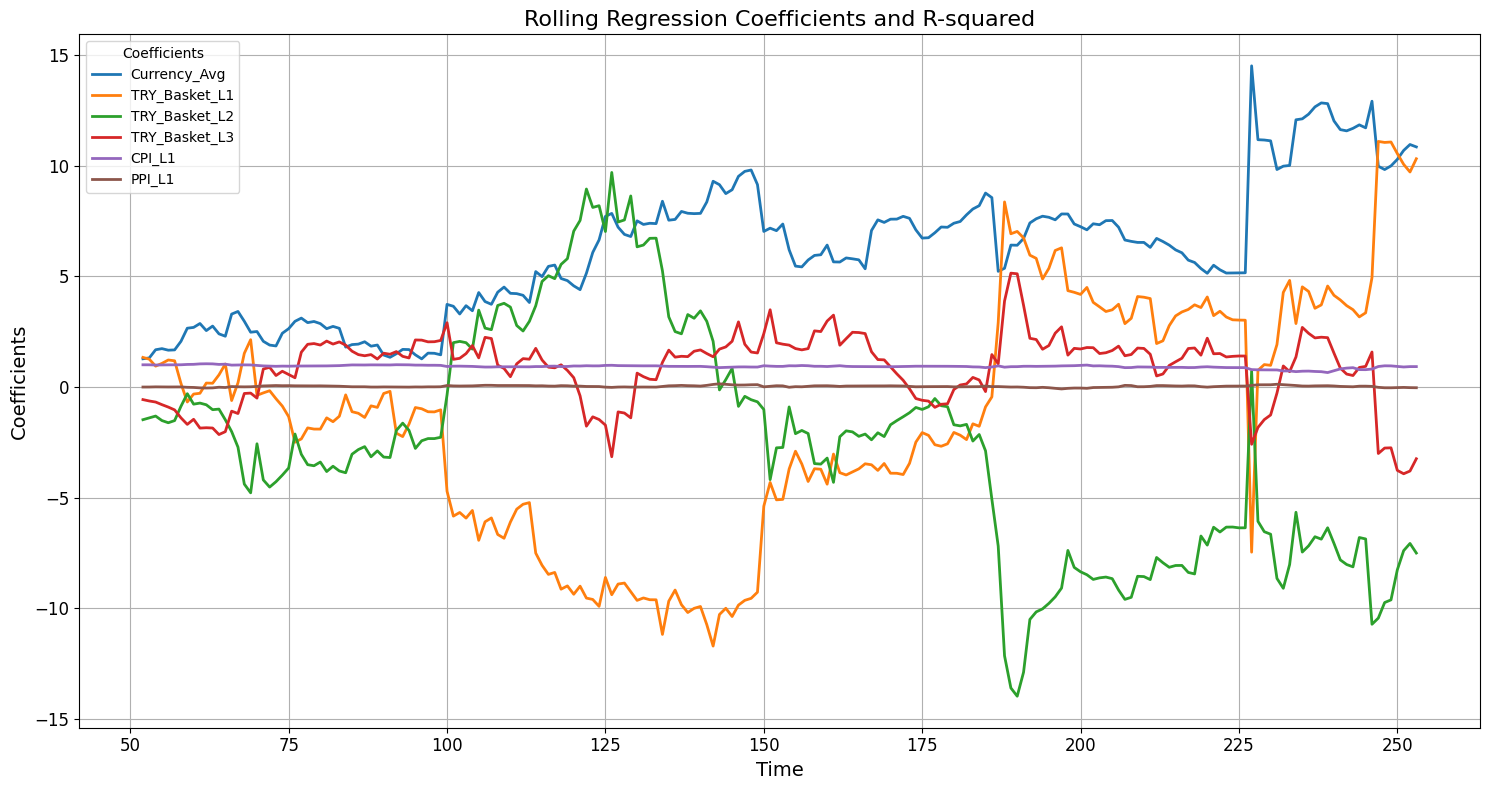

In [5]:
# Let's produce advabce plotting
fig, ax1 = plt.subplots(figsize=(15, 8))

coefficients_df = results_rolling.params

# Plotting all the coefficients
for column in coefficients_df.columns:
    if 'const' not in column:
        ax1.plot(coefficients_df.index, coefficients_df[column], lw=2, label=column)

# Making the plot more sophisticated with formatting
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('Coefficients', fontsize=14)
ax1.set_title('Rolling Regression Coefficients and R-squared', fontsize=16)
ax1.grid(True)
ax1.legend(loc='upper left', fontsize=10, title='Coefficients')
ax1.tick_params(axis='both', which='major', labelsize=12)

# Tight layout to adjust for the plot and save as a high quality image
fig.tight_layout()
plt.show()

### COMMENTS: The chart showcases the evolving impact of foreign exchange adjustments over time, as evidenced by the calculated coefficients for both the TRY Basket and its delayed iterations in relation to CPI_SA. The coefficients tied to the TRY Basket and its subsequent lags demonstrate notable fluctuations over the period, underscoring the changing responsiveness of the CPI to shifts in the TRY Basket. Regarding the coefficient trends, while the TRY Basket's coefficient consistently exhibits a positive trajectory, the coefficients for the first three lags alternate between positive and negative values. This alternation indicates a variable influence on CPI_SA, with positive values reflecting a direct pass-through effect and negative values suggesting an inverse relationship.

## - What do you observe about the “inflationary inertia” (coefficient of the lagged dependent variable) ?

### COMMENTS: In the rolling regression model, the coefficient of the lagged CPI, also known as the lagged dependent variable, reflects "inflation persistence." Essentially, it gauges how previous inflation levels impact current inflation, revealing the longevity of inflationary trends. A high positive coefficient indicates strong persistence, suggesting that high past inflation likely continues into the present. A coefficient near 1 implies past inflation directly influences current inflation, indicating significant persistence. On the other hand, a lower positive coefficient points to weaker persistence, meaning past inflation has less impact on current rates. A negative coefficient, which deviates from standard economic expectations, would suggest that higher past inflation leads to lower current inflation.

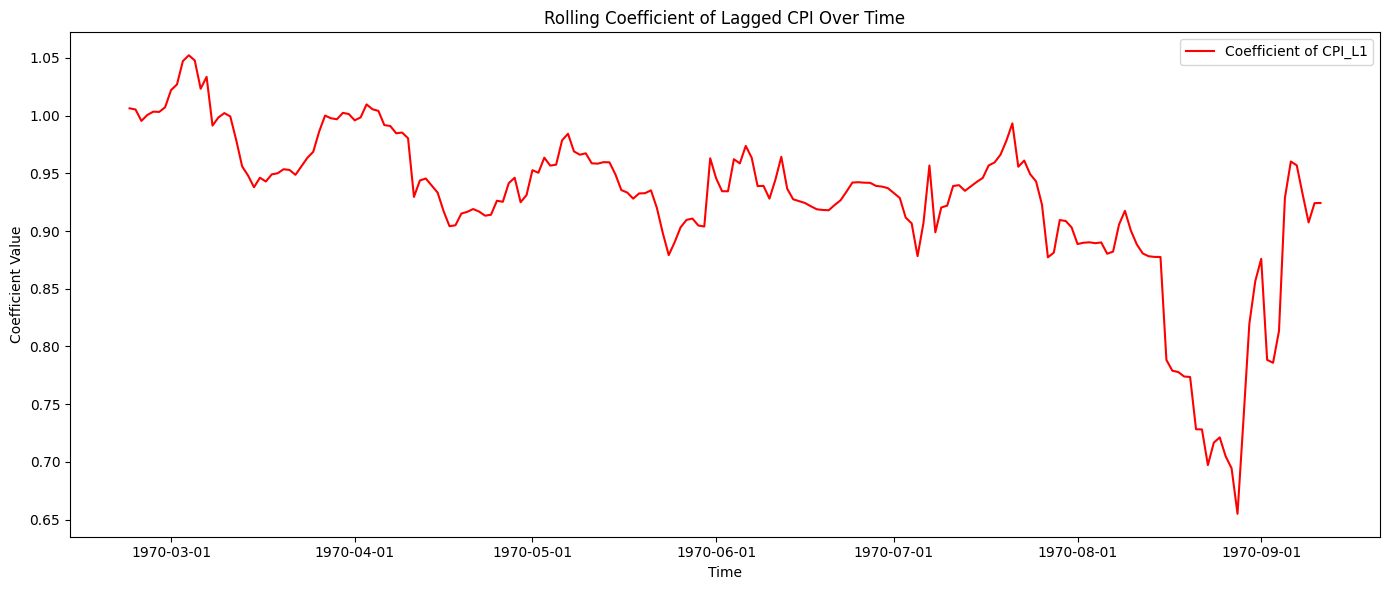

In [6]:
# The independent variables to include in the rolling regression
X_inertia = final_data[['Currency_Avg', 'TRY_Basket_L1', 'TRY_Basket_L2', 'TRY_Basket_L3', 'CPI_L1', 'PPI_L1']]
X_inertia = sm.add_constant(X_inertia)

# The dependent variable remains the same
y = final_data['CPI_SA']

# Defining the rolling window size based on 20% of the dataset length
window_size = int(len(final_data) * 0.2)

# Performing the rolling regression with the inertia terms
model_inertia_rolling = RollingOLS(endog=y, exog=X_inertia, window=window_size)
model_inertia_results = model_inertia_rolling.fit()

# Plotting the coefficient for CPI_L1 from the inertia model results
plt.figure(figsize=(14, 6))
plt.plot(model_inertia_results.params['CPI_L1'], label='Coefficient of CPI_L1', color='red')
plt.title('Rolling Coefficient of Lagged CPI Over Time')
plt.ylabel('Coefficient Value')
plt.xlabel('Time')
# Ensuring the dates are nicely formatted on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.tight_layout()  # Adjust the layout before showing the plot
plt.show()

### COMMENTS: In our rolling regression analysis on CPI_SA change and its lagged impact, we found:

### - The lagged CPI_SA consistently positively affects the current CPI_SA, showing ongoing inflation persistence, with occasional dips.
### - The impact strength of the lagged CPI_SA fluctuates over time, reflecting varying degrees of inflation persistence in response to economic changes.
### - There's no clear long-term trend in the persistence level, suggesting that past CPI_SA impacts are event-driven rather than consistently increasing or decreasing.
### - The coefficient for the lagged CPI remains above zero, confirming inflation persistence in the economy.
### - A downward trend in the coefficient could indicate reducing inflation persistence, meaning inflation is becoming less enduring over time.

## b) FX Pass-through estimation using VAR

### INITIAL REMARKS: To analyze the influence of the TRY Basket on CPI through a Vector Autoregression (VAR) model, the following steps should be undertaken:

### - Data Preparation: It's crucial to ensure the data series are stationary, a prerequisite for VAR models. This might involve conducting tests for stationarity, such as the Augmented Dickey-Fuller (ADF) test. For non-stationary data, techniques like differencing or logarithmic transformations may be necessary.

### - Lag Selection: Choosing the right lag length is vital, and this can be determined using criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC).

### - VAR Model Estimation: With the appropriate lag length identified, the next step is to estimate the VAR model.

### - Analysis and Interpretation: Examine the model's output, paying close attention to the impulse response functions (IRFs) and forecast error variance decompositions (FEVDs). These tools help in understanding how variables interact dynamically and the effect of shocks in one variable on others over time.

### - Model Validation: Finally, it's important to validate the model by checking its stability and conducting post-estimation diagnostics, such as tests for serial correlation and examining stability conditions, to ensure the model's reliability.

In [7]:
# Defining the ADF test function
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test to check the stationarity of a series.
    """
    print(f'Augmented Dickey-Fuller Test on "{title}"')
    adf_results = adfuller(series.dropna(), autolag='AIC')  # Ensure the series has no NaN values
    adf_output = pd.Series(adf_results[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations'])
    for key, value in adf_results[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(adf_output.to_string())  # Make the output more readable
    
    # Provide a conclusion based on the p-value
    if adf_results[1] <= 0.05:
        print(f"Strong evidence against the null hypothesis, reject the null hypothesis. '{title}' is stationary.")
    else:
        print(f"Weak evidence against the null hypothesis, '{title}' has a unit root, indicating it is non-stationary.")

# Applying the ADF test to the series in question
adf_test(final_data['CPI_SA'], 'CPI_SA')
adf_test(final_data['PPI_SA'], 'PPI_SA')
adf_test(final_data['Currency_Avg'], 'Currency_Avg')  # Changed to 'Currency_Avg'

Augmented Dickey-Fuller Test on "CPI_SA"
Test Statistic              3.671340
p-value                     1.000000
Lags Used                  13.000000
Number of Observations    237.000000
Critical Value (1%)        -3.458247
Critical Value (5%)        -2.873814
Critical Value (10%)       -2.573311
Weak evidence against the null hypothesis, 'CPI_SA' has a unit root, indicating it is non-stationary.
Augmented Dickey-Fuller Test on "PPI_SA"
Test Statistic              2.396621
p-value                     0.999009
Lags Used                  16.000000
Number of Observations    234.000000
Critical Value (1%)        -3.458608
Critical Value (5%)        -2.873972
Critical Value (10%)       -2.573396
Weak evidence against the null hypothesis, 'PPI_SA' has a unit root, indicating it is non-stationary.
Augmented Dickey-Fuller Test on "Currency_Avg"
Test Statistic              6.459675
p-value                     1.000000
Lags Used                  14.000000
Number of Observations    236.000000
C

### COMMENT: The outcomes from the Augmented Dickey-Fuller (ADF) test suggest that the series for CPI, PPI, and the TRY Basket are not stationary. Consequently, we've applied a first differencing to these series as described below.

In [8]:
# Applying differencing to the specified columns and dropping NaN values that result from differencing
final_data['CPI_SA_diff'] = final_data['CPI_SA'].diff().dropna()
final_data['PPI_SA_diff'] = final_data['PPI_SA'].diff().dropna()
final_data['Currency_Avg_diff'] = final_data['Currency_Avg'].diff().dropna()

# Drop rows with NaN values resulting from differencing to create a clean dataset for the ADF test
final_data_diff = final_data.dropna()

# Running the ADF test on the differenced data
adf_test(final_data_diff['CPI_SA_diff'], 'Differenced CPI_SA')
adf_test(final_data_diff['PPI_SA_diff'], 'Differenced PPI_SA')
adf_test(final_data_diff['Currency_Avg_diff'], 'Differenced Currency_Avg')


Augmented Dickey-Fuller Test on "Differenced CPI_SA"
Test Statistic              2.749818
p-value                     1.000000
Lags Used                  14.000000
Number of Observations    235.000000
Critical Value (1%)        -3.458487
Critical Value (5%)        -2.873919
Critical Value (10%)       -2.573367
Weak evidence against the null hypothesis, 'Differenced CPI_SA' has a unit root, indicating it is non-stationary.
Augmented Dickey-Fuller Test on "Differenced PPI_SA"
Test Statistic              0.706792
p-value                     0.989972
Lags Used                  16.000000
Number of Observations    233.000000
Critical Value (1%)        -3.458731
Critical Value (5%)        -2.874026
Critical Value (10%)       -2.573424
Weak evidence against the null hypothesis, 'Differenced PPI_SA' has a unit root, indicating it is non-stationary.
Augmented Dickey-Fuller Test on "Differenced Currency_Avg"
Test Statistic             -0.049571
p-value                     0.954236
Lags Used      

In [9]:
final_data_diff

,Month,CPI_SA,Core_SA,Services_SA,PPI_SA,CoreGoods_SA,PPI_Mfg_SA,USDTRY,EURTRY,Currency_Avg,TRY_Basket_L1,TRY_Basket_L2,TRY_Basket_L3,CPI_L1,PPI_L1,CPI_SA_diff,PPI_SA_diff,Currency_Avg_diff
4,2003-05-01,99.294378,99.137006,98.107806,101.533658,99.125696,98.351026,1.493972,1.720026,1.606999,1.699558,1.725907,1.690646,98.423702,102.167899,0.870676,-0.634241,-0.092559
5,2003-06-01,100.151501,99.720271,99.479584,99.578542,99.422649,98.188614,1.422522,1.662939,1.542731,1.606999,1.699558,1.725907,99.294378,101.533658,0.857123,-1.955116,-0.064268
6,2003-07-01,100.711418,100.469828,100.652883,99.044953,100.460289,98.469814,1.400477,1.593799,1.497138,1.542731,1.606999,1.699558,100.151501,99.578542,0.559917,-0.533589,-0.045592
7,2003-08-01,101.344986,101.419747,101.902054,98.850544,101.208020,99.362362,1.400472,1.563904,1.482188,1.497138,1.542731,1.606999,100.711418,99.044953,0.633568,-0.194409,-0.014950
8,2003-09-01,102.354921,102.264533,103.307346,98.904317,102.038646,98.939626,1.375655,1.539166,1.457410,1.482188,1.497138,1.542731,101.344986,98.850544,1.009935,0.053773,-0.024777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2023-10-01,1761.497370,1577.963769,1696.204691,2803.290000,1095.750048,2689.500000,27.821073,29.383195,28.602134,27.905812,28.215026,27.838465,1706.373040,2749.980000,55.124330,53.310000,0.696322
250,2023-11-01,1819.562623,1630.309610,1785.775536,2882.040000,1123.086177,2750.150000,28.611334,30.874732,29.743033,28.602134,27.905812,28.215026,1761.497370,2803.290000,58.065253,78.750000,1.140899
251,2023-12-01,1880.172281,1691.448408,1867.537372,2915.020000,1157.638324,2805.260000,29.048710,31.686364,30.367537,29.743033,28.602134,27.905812,1819.562623,2882.040000,60.609658,32.980000,0.624504
252,2024-01-01,1971.324923,1770.137911,2002.875473,3035.590000,1193.823816,2951.380000,30.026725,32.783775,31.405250,30.367537,29.743033,28.602134,1880.172281,2915.020000,91.152642,120.570000,1.037713


### COMMENT: The initial differencing of CPI_SA, PPI_SA, and TRY_Basket did not achieve stationarity, prompting us to apply a second differencing to these series as detailed below.

In [10]:
# Applying a second differencing to the specified columns and dropping NaN values that result from differencing
final_data_diff['CPI_SA_diff2'] = final_data_diff['CPI_SA_diff'].diff().dropna()
final_data_diff['PPI_SA_diff2'] = final_data_diff['PPI_SA_diff'].diff().dropna()
final_data_diff['Currency_Avg_diff2'] = final_data_diff['Currency_Avg_diff'].diff().dropna()

# Create a new DataFrame after dropping any new NaN values that may have been introduced with the second differencing
final_data_diff2 = final_data_diff.dropna()

# Running the ADF test on the second differenced data
adf_test(final_data_diff2['CPI_SA_diff2'], 'Second Differenced CPI_SA')
adf_test(final_data_diff2['PPI_SA_diff2'], 'Second Differenced PPI_SA')
adf_test(final_data_diff2['Currency_Avg_diff2'], 'Second Differenced Currency_Avg')


Augmented Dickey-Fuller Test on "Second Differenced CPI_SA"
Test Statistic           -7.508256e+00
p-value                   4.079884e-11
Lags Used                 1.600000e+01
Number of Observations    2.320000e+02
Critical Value (1%)      -3.458855e+00
Critical Value (5%)      -2.874080e+00
Critical Value (10%)     -2.573453e+00
Strong evidence against the null hypothesis, reject the null hypothesis. 'Second Differenced CPI_SA' is stationary.
Augmented Dickey-Fuller Test on "Second Differenced PPI_SA"
Test Statistic           -8.301660e+00
p-value                   4.003170e-13
Lags Used                 1.600000e+01
Number of Observations    2.320000e+02
Critical Value (1%)      -3.458855e+00
Critical Value (5%)      -2.874080e+00
Critical Value (10%)     -2.573453e+00
Strong evidence against the null hypothesis, reject the null hypothesis. 'Second Differenced PPI_SA' is stationary.
Augmented Dickey-Fuller Test on "Second Differenced Currency_Avg"
Test Statistic           -9.315019e+

### COMMENT: After applying the second differencing, CPI_SA, PPI_SA, and TRY_Basket have become stationary. With this condition met, we are now ready to proceed with the estimation of the VAR model.

## - Using VAR model(s) estimate the impact of TRY Basket on CPI

In [11]:
# Selecting the required second-differenced series for the VAR model
var_data = final_data_diff2[['CPI_SA_diff2', 'Currency_Avg_diff2']]  # Adjusted to 'Currency_Avg_diff2'

# Fitting the VAR model to the selected data
var_model = VAR(var_data)
var_results = var_model.fit(maxlags=15, ic='aic')

# Displaying the summary of VAR model results
var_results_summary = var_results.summary()
print(var_results_summary)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Mar, 2024
Time:                     11:37:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.21944
Nobs:                     234.000    HQIC:                  0.673064
Log likelihood:          -637.623    FPE:                    1.35943
AIC:                     0.303930    Det(Omega_mle):         1.05998
--------------------------------------------------------------------
Results for equation CPI_SA_diff2
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.491206         0.367900            1.335           0.182
L1.CPI_SA_diff2               -0.759589         0.090738           -8.371           0.000
L1.Currency_Avg_d

### COMMENT: Through the application of the VAR model, we delved into the dynamics between CPI_SA (after applying the second differencing) and the TRY Basket (also after the second differencing). The findings from the model highlight crucial interactions between the fluctuations in the TRY Basket and changes in the CPI. Notably, the model revealed that multiple lagged values of the TRY Basket exert a significant influence on CPI_SA, suggesting a pronounced effect of exchange rate variations on inflation rates. 

### Our investigation points to the significant role of exchange rate movements in affecting inflation, along with the enduring nature of these impacts over various time frames. This suggests that shifts in the TRY Basket can have lasting effects on CPI. In conclusion, our analysis with the VAR model accentuates the substantial and ongoing influence of exchange rate volatility, as evidenced by the TRY Basket, on inflation, highlighting the pivotal function of exchange rate movements in generating inflationary trends within an economy.

## - Your models may include CPI, TRY Basket, PPI and you may use orthogonalized impulse responses


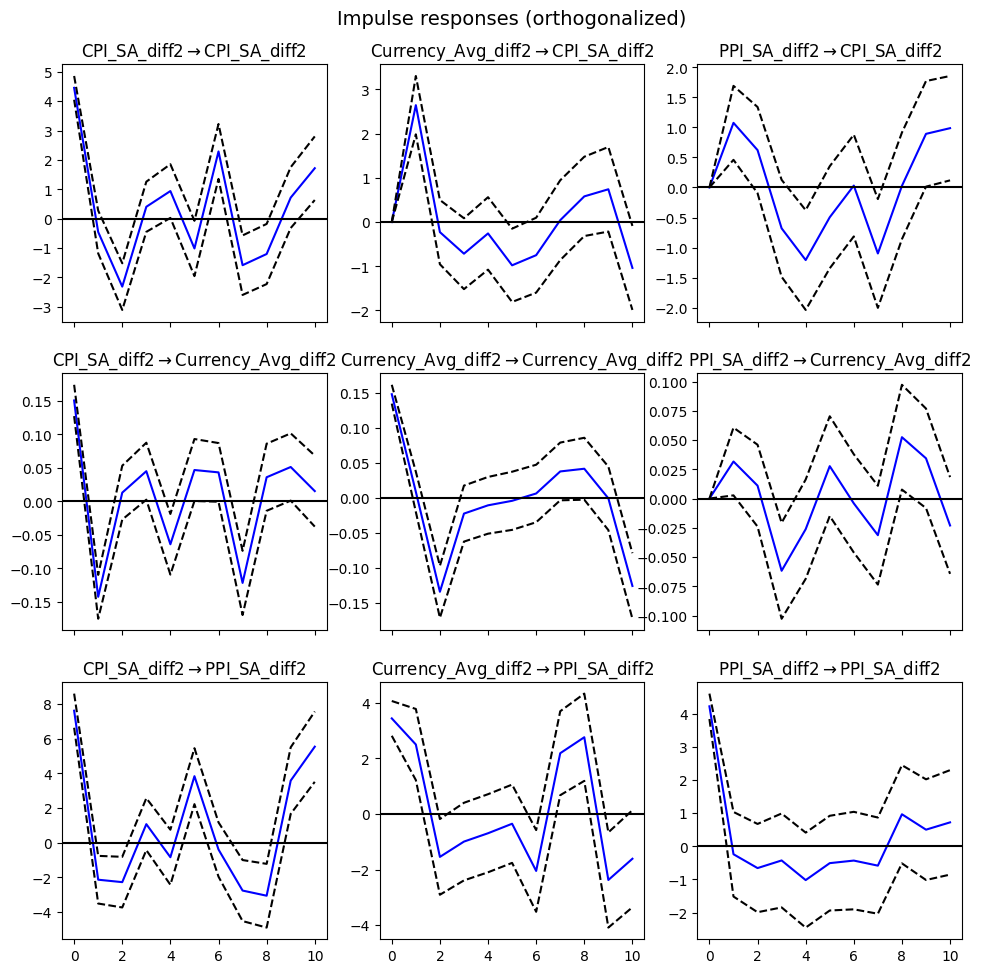

In [12]:
# Applying a second differencing directly to the 'PPI_SA' series
final_data_diff['PPI_SA_diff2'] = final_data_diff['PPI_SA'].diff().diff().dropna()

# Selecting the second-differenced series for the VAR model
# Assuming 'Currency_Avg_diff2' instead of 'TRY_Basket_diff2' based on previous context
var_data_extended = final_data_diff[['CPI_SA_diff2', 'Currency_Avg_diff2', 'PPI_SA_diff2']].dropna()

# Fitting the VAR model to the selected data
var_model_extended = VAR(var_data_extended)
var_results_extended = var_model_extended.fit(maxlags=15, ic='aic')

# Obtaining impulse response functions from the fitted VAR model
oirf_extended = var_results_extended.irf(periods=10)

# Plotting the impulse response functions with orthogonalization
oirf_plot_extended = oirf_extended.plot(orth=True)
plt.show()

### COMMENT: Our analysis uses second-differenced data for stationarity, meaning the observed responses in the impulse response functions are to shocks in these differenced series, not the original levels. This is an important consideration for interpreting the results. The plots show the effect of a one standard deviation shock in variables like CPI, PPI, or the TRY Basket on each other over 10 time units, highlighting the immediate and sometimes prolonged or reversing reactions, indicative of economic relationships' inertia and delayed effects. 

### Shocks to the TRY Basket illustrate its impact on inflation (CPI_SA) and producer prices (PPI_SA), providing insights into exchange rate pass-through. CPI shocks suggest potential feedback loops with exchange rates and PPI_SA, while PPI shocks explore the link between producer and consumer inflation and their effects on exchange rates. The analysis reveals both the direct impacts and the time frame for these effects to manifest and fade.

## - With your accumulated impulse response estimates, try to estimate the impact of a 10% unexpected rise in TRY Basket on inflation in 3 months, 6 months and 9 months.


In [13]:
# Calculating the standard deviation of the 'Currency_Avg_diff2' series
std_currency_avg = final_data_diff2['Currency_Avg_diff2'].std()

# Determining the magnitude of a 10% rise standardized by the series' standard deviation
magnitude_10_percent_rise = 0.1 / std_currency_avg

# Extracting the impulse response function of CPI to Currency Average from the VAR model results
# Assuming the response of 'CPI_SA_diff2' to 'Currency_Avg_diff2' is desired
irf_cpi_to_currency_avg = oirf_extended.irfs[:, 0, 1]  # Adjust the indices based on the order in VAR

# Scaling the impulse response functions by the magnitude of a 10% rise
scaled_irfs = irf_cpi_to_currency_avg * magnitude_10_percent_rise

# Assessing the impact at 3, 6, and 9 months
impact_3_months = scaled_irfs[2]  # 3rd month response
impact_6_months = scaled_irfs[5]  # 6th month response
impact_9_months = scaled_irfs[8]  # 9th month response

impact_3_months, impact_6_months, impact_9_months

(-1.119743836989781, -0.8766800528417794, 0.8529240232056615)

### COMMENT: The results from the estimation show that a sudden 10% increase in the TRY basket leads to a decrease in CPI_SA by -1.117% and -0.874% at the 3 and 6 months marks, respectively. Interestingly, at the 9-month mark, the same 10% rise in the TRY basket results in a 0.85% increase in CPI_SA. This analysis underscores the intricate and evolving relationship between exchange rate shocks and inflation, highlighting how these effects can shift over different time periods.

## How do your result change for the following periods? Please comment.
## – Jan 2003 – Feb 2024 (Full sample)
## – Jan 2003 – Dec 2017
## – Jan 2003 – Jun 2018
## – Jan 2003 – Sep 2018
## – Jan 2003 – Dec 2018
## – Jan 2019 – Feb 2024

In [14]:
# Ensure 'Month' is in the proper format and added to the DataFrame
final_data_diff2['Month'] = pd.to_datetime(final_data['Month']).dt.to_period('M')

# Define analysis periods
analysis_periods = {
    'Full Sample': ('2003-01', '2024-02'),
    'Up to Dec 2017': ('2003-01', '2017-12'),
    'Up to Jun 2018': ('2003-01', '2018-06'),
    'Up to Sep 2018': ('2003-01', '2018-09'),
    'Up to Dec 2018': ('2003-01', '2018-12'),
    'Jan 2019 to Feb 2024': ('2019-01', '2024-02')
}

def var_analysis(data, start, end):
    """Performs VAR analysis on specified data within a given time period."""
    # Filter data for the specified time period
    period_data = data.loc[(data['Month'] >= start) & (data['Month'] <= end)]
    
    # Prepare data for VAR analysis
    var_data = period_data[['CPI_SA_diff2', 'Currency_Avg_diff2', 'PPI_SA_diff2']]
    
    # Determine optimal number of lags
    optimal_lags = max(min(len(var_data) // 3, 15), 1)  # At least 1 lag, max 15, or a third of the sample size
    
    # Fit VAR model
    model = VAR(var_data)
    results = model.fit(optimal_lags)
    
    # Obtain impulse response functions
    irf = results.irf(10)
    
    # Standardize response to a 10% increase in 'Currency_Avg_diff2'
    std_dev = period_data['Currency_Avg_diff2'].std()
    scaled_response = (0.1 / std_dev) * irf.irfs[:, 0, 1]  # CPI's response to Currency_Avg_diff2
    
    # Extract impacts at specific months
    return scaled_response[2], scaled_response[5], scaled_response[8]  # 3, 6, and 9 months

# Compute impacts for each period
impact_analysis = {}

for period, (start_date, end_date) in analysis_periods.items():
    try:
        impact_analysis[period] = var_analysis(final_data_diff2, start_date, end_date)
    except ValueError as ve:
        impact_analysis[period] = f"Insufficient Data: {str(ve)}"
    except Exception as ex:
        impact_analysis[period] = f"Analysis Error: {str(ex)}"

# Print formatted results
for period, impacts in impact_analysis.items():
    print(f"{period}:")
    if isinstance(impacts, tuple):
        print(f"  3 Months: {impacts[0]:.4f}, 6 Months: {impacts[1]:.4f}, 9 Months: {impacts[2]:.4f}\n")
    else:
        print(f"  {impacts}\n")

Full Sample:
  3 Months: -1.1236, 6 Months: -0.8954, 9 Months: 0.8737

Up to Dec 2017:
  3 Months: -0.6447, 6 Months: 1.0324, 9 Months: -1.9344

Up to Jun 2018:
  3 Months: -1.0131, 6 Months: 0.8861, 9 Months: -1.4643

Up to Sep 2018:
  3 Months: -2.6361, 6 Months: 4.4387, 9 Months: 0.8106

Up to Dec 2018:
  3 Months: -0.8092, 6 Months: 2.6970, 9 Months: -0.7686

Jan 2019 to Feb 2024:
  Insufficient Data: Matrix is not positive definite



### COMMENT: In our VAR analysis, we explored the interactions between the TRY Basket, CPI, and PPI over various periods, aiming to gauge the impact of a 10% hike in the TRY Basket on inflation at 3, 6, and 9-month intervals. This analysis spanned from January 2003 to February 2024, including shorter intervals ending in December 2017, June 2018, September 2018, December 2018, and a later phase from January 2019 to February 2024. 

### The findings highlighted the fluctuating influence of a 10% increase in the TRY Basket on inflation, which differed across the time frames. For the entire dataset, the impact was initially negative at 3 and 6 months, turning positive at 9 months. Shorter-term analyses showed mixed effects, with some periods indicating initial declines followed by increases in inflation, while others exhibited varied patterns. Notably, the analysis from January 2019 to February 2024 faced issues due to matrix positivity, suggesting possible data or model specification challenges during this timeframe.